# Open Program - Capsule Networks
This notebook is explains how Capsule Networks work and can be applied.

## 0. Preparation
In this section useful libraries are imported which are used in most data science projects.

In [1]:
import os
import sys

# sets the path to the home directory of this repository so other modules can be imported. 
project_path = os.getcwd()
root_path = os.path.split(os.path.split(os.getcwd())[0])[0]
assert root_path.endswith("Fontys-ADS"), "The root path does not end with Fontys-ADS: " + root_path 
sys.path.insert(0, root_path)

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# for easily displaying images
from IPython.display import Image

# set the seed for reproducible results.
np.random.seed(56)
tf.random.set_seed(56)

## 1. What are Capsule Neural Networks?
d

## 2. Implementation
In this notebook, the proposed architecture from the paper [Dynamic Routing Between Capsules](https://arxiv.org/abs/1710.09829) for solving MNIST is implemented. <br>

<figure class="image">
  <img src="Capsule-network-mnist.jpg" alt="Capsule Network MNIST">
  <figcaption> 1. Capsule Network MNIST.</figcaption>
</figure>
As seen in figure 1, the architecture has 2 new components in model building. <br>
A PrimaryCap layer and a DigitCap layer. In the following chapters these layers will be implemented and explained.

### 2.1 Squashing Activation Function
The squashing activation function is a non-linear activation function used with capsule layers.<br>
The length of the output vector of a capsule to represents the probability that the entity <br>
represented by the capsule is present in the current input. A non-linear "squashing" <br>
function is used to ensure that short vectors get shrunk to almost zero length and long vectors get shrunk to a <br>
length slightly below 1. <br> <br>
 In the paper it is stated that they leave it to discriminative learning to make good use of this non-linearity. <br>

\begin{multline*}
    {\bf v}_j = \frac{||{\bf s}_j||^2}{1+||{\bf s}_j||^2} \frac{{\bf s}_j}{||{\bf s}_j||}
\end{multline*}
where ${\bf v}_j$ is the vector output of capsule $j$ and ${\bf s}_j$ is its total input.

In [3]:
from tensorflow.keras import backend as K

class SquashActivationLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(SquashActivationLayer, self).__init__()
        # ---------------------------- Squash Activation Layer ----------------------------

    def call(self, vectors):
        # Added epsilon to prevent division by zero errors.
        norm = tf.norm(vectors, axis=-1, keepdims=True) + K.epsilon()
        squared_norm = tf.square(norm)
        scaling = vectors / norm
        additional_squashing = squared_norm / (1 + squared_norm)
        return additional_squashing * scaling

### 2.2 Primary Capsule Layer

In [4]:
from tensorflow.keras.layers import Layer, Conv2D, Reshape, Input

class PrimaryCapsuleLayer(Layer):
    def __init__(self, channels, capsule_dimension, kernel_size, strides):
        super(PrimaryCapsuleLayer, self).__init__()
        # ---------------------------- Primary Capsule Layer ----------------------------

        # 1. convolutional layer.
        capsule_filters = capsule_dimension * channels
        self.conv1_layer = Conv2D(filters=capsule_filters, kernel_size=kernel_size, strides=strides, padding='valid', name='PrimaryCapsuleLayer_Conv2D')
        
        # 2. reshape layer for 1D outputs.
        self.reshape_layer = Reshape(target_shape=(-1, capsule_dimension))

        # 3. squashing outputs.
        self.squash_activation_layer = SquashActivationLayer()

    def call(self, inputs):
        # tf.print(f'PrimaryCapsuleLayer -> Inputs shape{inputs.shape}')
        x = self.conv1_layer(inputs)
        # tf.print(f'PrimaryCapsuleLayer -> Conv1 shape{x.shape}')
        x = self.reshape_layer(x)
        # tf.print(f'PrimaryCapsuleLayer -> Reshape shape{x.shape}')
        x = self.squash_activation_layer(x)
        # tf.print(f'PrimaryCapsuleLayer -> Squash shape{x.shape}')
        return x

### 2.3 Capsule Layer With Routing

In [5]:
class CapsuleLayer(Layer):
    def __init__(self, capsules):
        super(CapsuleLayer, self).__init__()
        # ---------------------------- Capsule Layer ----------------------------
        

    def call(self):
        pass

### 2.4 MNIST Capsule Network

In [6]:
class MNISTCapsuleNetwork(tf.keras.Model):
    def __init__(self, image_dimensions):
        super(MNISTCapsuleNetwork, self).__init__()
        # ---------------------------- MNIST Capsule Network ----------------------------
        # set image dimensions.
        self.image_height, self.image_width, self.image_channels = image_dimensions

        # MNIST contains 10 classes: 0, 1, 2, 3, 4, 5, 6, 7, 8 and 9.
        self.classes = 10

        # 1. first convolutional layer
        # this layer converts pixel intensities to the activities of 
        # local feature detectors that are then used as inputs to the primary capsules.
        self.conv1 = Conv2D(filters=256, kernel_size=9, strides=1, activation='relu')

        # 2. primary capsule layer
        self.primary_capsule_layer = PrimaryCapsuleLayer(channels=32, capsule_dimension=8, kernel_size=9, strides=2)

    def call(self, inputs):
        # tf.print(f'Inputs shape{inputs.shape}')
        x = self.conv1(inputs)
        # tf.print(f'Conv1 shape{x.shape}')
        x = self.primary_capsule_layer(x)
        # tf.print(f'Primary Capsule shape{x.shape}')
        return x

In [7]:
img = tf.random.uniform((10, 28, 28, 1), maxval=1.)
target = tf.reduce_mean(tf.reshape(img, (10, 28 * 28)), axis=-1)

In [8]:
target

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.50296915, 0.49709627, 0.5028499 , 0.50024956, 0.48357898,
       0.49984592, 0.5002002 , 0.50537235, 0.5022704 , 0.50390977],
      dtype=float32)>

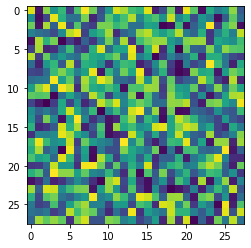

In [9]:
plt.imshow(img.numpy()[0])

In [10]:
image_dimensions = (28, 28, 1)

model = MNISTCapsuleNetwork(image_dimensions)
model.build(img.shape)
model.compile(loss='mse')
model.summary(line_length=144)
res = model.fit(img, target, epochs=10, batch_size=1, verbose=1)

Model: "mnist_capsule_network"
________________________________________________________________________________________________________________________________________________
Layer (type)                                                    Output Shape                                              Param #               
conv2d (Conv2D)                                                 multiple                                                  20992                 
________________________________________________________________________________________________________________________________________________
primary_capsule_layer (PrimaryCapsuleLayer)                     multiple                                                  5308672               
Total params: 5,329,664
Trainable params: 5,329,664
Non-trainable params: 0
________________________________________________________________________________________________________________________________________________
Epoch 1/10
10/10 [=====

In [11]:
output = model.predict(img)

In [12]:
for layer in model.layers:
    print(layer.output_shape)

AttributeError: The layer has never been called and thus has no defined output shape.

In [12]:
output.shape

(10, 1152, 8)